In [1]:
!pip install tensorflow_addons
!pip install keras-tuner --upgrade

# clone siren repository, refresh folder to see the siren repository
# runtime -> change runtime -> choose a gpu/tpu
!git clone https://github.com/hubtru/Siren/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.7 MB/s eta 0:00:00
Cloning into 'Siren'...
remote: Enumerating objects: 313, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 313 (delta 9), reused 7 (delta 2), pack-reused 297
Receiving objects: 100% (313/313), 57.54 MiB | 18.87 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras as k
from keras import layers
from sklearn.model_selection import train_test_split
import cv2
import os

os.environ["CUDA_VISIBLE_DEVICES"]="1"

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
# ============================== gpu info ==============================
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
print("GPUs: ", tf.config.list_physical_devices("GPU"))

Num GPUs Available:  0
GPUs:  []


In [4]:
# ============================== variables ==============================
# architecture
image_size = 256
filters = 256
depth = 4
columns = 4
kernel_size = 5
patch_size = 16
num_classes = 3

in_channel = 9
img_rows, img_cols = image_size, image_size
input_shape = (img_rows, img_cols, in_channel)

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 8
epochs = 100

In [17]:
# ============================== paths ==============================
# needed for generate_data
modality = "spec"
exp_name = f"siren_reg"
sub_exp_name = f"base"
model_name = f"{exp_name}_{sub_exp_name}_{modality}"
model_save_path = f"{model_name}.h5"

# dataset
csv_path = "/content/Siren/dataset/labels_reg_sample.csv"
spec_path = f"/content/Siren/dataset/{modality}"

In [18]:
# ============================== load/prepare dataset ==============================
df = pd.read_csv(csv_path)

# RANDOM DATASET: we switch to toolbased
# shuffle, need same state for tool/spec/chips/multi
np.random.seed(55)
df = df.iloc[np.random.permutation(len(df))]
# train/test/val : 70/15/15
train_df, test_df = train_test_split(df, test_size=0.3)
test_df, val_df = train_test_split(test_df, test_size=0.5)

print(
    "size check train/test/val",
    len(train_df),
    len(test_df),
    len(val_df),
    (len(train_df) + len(test_df) + len(val_df)),
)

train_df["spec_x"] = train_df.id.map(lambda id: f"{spec_path}/x/{id}.jpg")
test_df["spec_x"] = test_df.id.map(lambda id: f"{spec_path}/x/{id}.jpg")
val_df["spec_x"] = val_df.id.map(lambda id: f"{spec_path}/x/{id}.jpg")

train_df["spec_y"] = train_df.id.map(lambda id: f"{spec_path}/y/{id}.jpg")
test_df["spec_y"] = test_df.id.map(lambda id: f"{spec_path}/y/{id}.jpg")
val_df["spec_y"] = val_df.id.map(lambda id: f"{spec_path}/y/{id}.jpg")

train_df["spec_z"] = train_df.id.map(lambda id: f"{spec_path}/z/{id}.jpg")
test_df["spec_z"] = test_df.id.map(lambda id: f"{spec_path}/z/{id}.jpg")
val_df["spec_z"] = val_df.id.map(lambda id: f"{spec_path}/z/{id}.jpg")


size check train/test/val 14 3 3 20


<Figure size 600x600 with 0 Axes>

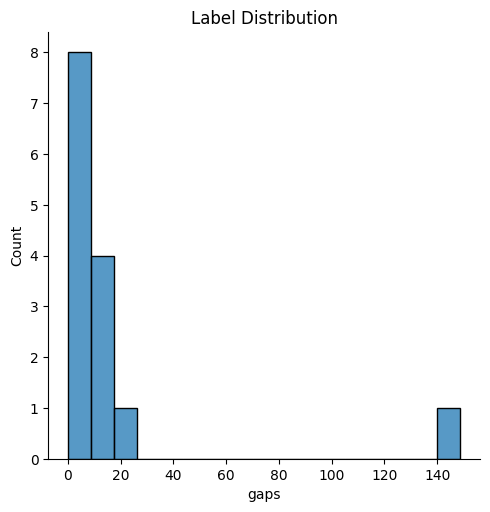

In [19]:
plt.figure(figsize=(6, 6))
sns.displot(train_df["gaps"])
plt.title("Label Distribution")
plt.show()

<Figure size 600x600 with 0 Axes>

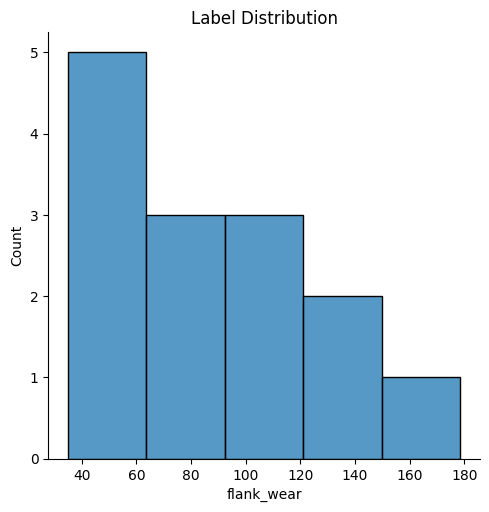

In [20]:
plt.figure(figsize=(6, 6))
sns.displot(train_df["flank_wear"])
plt.title("Label Distribution")
plt.show()

<Figure size 600x600 with 0 Axes>

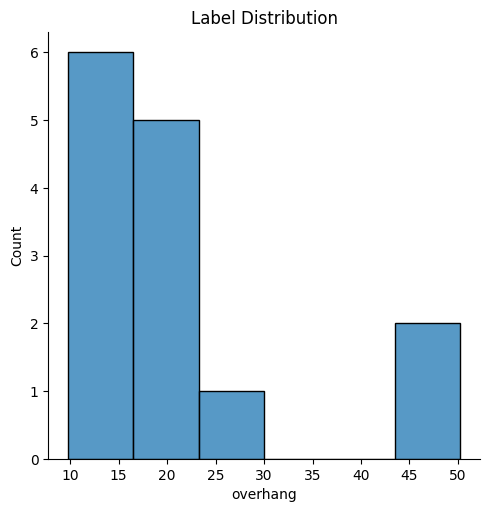

In [21]:
plt.figure(figsize=(6, 6))
sns.displot(train_df["overhang"])
plt.title("Label Distribution")
plt.show()

In [22]:
print("check if permutation is same on all models")
print("train_head", train_df.head())
print("test_head", test_df.head())
print("val_head", val_df.head())

check if permutation is same on all models
train_head          id   gaps  flank_wear  overhang  \
14   T8R3B4   6.88       40.92     14.54   
10   T6R9B3  12.94       95.63     16.65   
0    T1R2B1   7.67       34.89     48.61   
3   T2R13B4   0.00      122.59     25.55   
1    T1R7B4  13.89       85.41     50.25   

                                       spec_x  \
14   /content/Siren/dataset/spec/x/T8R3B4.jpg   
10   /content/Siren/dataset/spec/x/T6R9B3.jpg   
0    /content/Siren/dataset/spec/x/T1R2B1.jpg   
3   /content/Siren/dataset/spec/x/T2R13B4.jpg   
1    /content/Siren/dataset/spec/x/T1R7B4.jpg   

                                       spec_y  \
14   /content/Siren/dataset/spec/y/T8R3B4.jpg   
10   /content/Siren/dataset/spec/y/T6R9B3.jpg   
0    /content/Siren/dataset/spec/y/T1R2B1.jpg   
3   /content/Siren/dataset/spec/y/T2R13B4.jpg   
1    /content/Siren/dataset/spec/y/T1R7B4.jpg   

                                       spec_z  
14   /content/Siren/dataset/spec/z/T8R3B4.j

In [23]:
def read_specs(file_paths_x, file_paths_y, file_paths_z, img_rows, img_cols, channels):
    """
    Reads the spectogram files from disk and normalizes the pixel values
      @params:
        file_paths - Array of file paths to read from
        img_rows - The image height.
        img_cols - The image width.
        as_grey - Read the image as Greyscale or RGB.
        channels - Number of channels.
      @returns:
        The created and compiled model (Model)
    """
    images = []

    for i in range(file_paths_x.size):
        img_x = cv2.imread(file_paths_x[i])
        res_x = cv2.resize(
            img_x, dsize=(img_rows, img_cols), interpolation=cv2.INTER_CUBIC
        )
        images.append(res_x)
        img_y = cv2.imread(file_paths_y[i])
        res_y = cv2.resize(
            img_y, dsize=(img_rows, img_cols), interpolation=cv2.INTER_CUBIC
        )
        images.append(res_y)
        img_z = cv2.imread(file_paths_z[i])
        res_z = cv2.resize(
            img_z, dsize=(img_rows, img_cols), interpolation=cv2.INTER_CUBIC
        )
        images.append(res_z)

    images = np.asarray(images, dtype=np.float32)

    # normalize
    images = images / np.max(images)

    # reshape to match Keras expectaions
    images = images.reshape(file_paths_x.shape[0], img_rows, img_cols, channels)

    return images

In [24]:
x_train_spec = read_specs(
    train_df.spec_x.values,
    train_df.spec_y.values,
    train_df.spec_z.values,
    img_rows,
    img_cols,
    in_channel,
)
x_test_spec = read_specs(
    test_df.spec_x.values,
    test_df.spec_y.values,
    test_df.spec_z.values,
    img_rows,
    img_cols,
    in_channel,
)
x_val_spec = read_specs(
    val_df.spec_x.values,
    val_df.spec_y.values,
    val_df.spec_z.values,
    img_rows,
    img_cols,
    in_channel,
)

In [25]:
x_train_spec.shape

(14, 256, 256, 9)

In [26]:
labels_train = train_df[["gaps", "flank_wear", "overhang"]]
labels_test = test_df[["gaps", "flank_wear", "overhang"]]
labels_val = val_df[["gaps", "flank_wear", "overhang"]]

In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_spec, labels_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_spec, labels_test))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_spec, labels_val))

In [28]:
# ============================== augment ==============================
auto = tf.data.AUTOTUNE

data_augmentation = k.Sequential(
    [
        k.layers.RandomBrightness(factor=(-0.2, 0.2), value_range=(0, 1)),
        k.layers.RandomContrast(factor=0.2),
        k.layers.GaussianNoise(stddev=0.2),
    ],
    name="data_augmentation",
)

In [29]:
def generate_datasets(images, is_train=False, shuffle=False):
    dataset = images
    if shuffle:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x), y), num_parallel_calls=auto
        )
    return dataset.prefetch(auto)

In [30]:
train_ds = generate_datasets(train_dataset, is_train=True, shuffle=True)
val_ds = generate_datasets(val_dataset)
test_ds = generate_datasets(test_dataset)

In [31]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>

In [32]:
#Functions
#Reversed Column implementation of Truchan (2023). Minape: Multimodal Isotropic Neural Architecture with Patch Embedding.
#https://github.com/hubtru/minape
def activation_module(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)


def base_module(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_module(x)


def depth_point_module(
    x, pe_block, column, level, depth, r_arr, filters: int, kernel_size: int
):
    if column == 0:
        # Depthwise convolution.
        x0 = x
        x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
        x = layers.Add()([activation_module(x), x0])  # Residual.

        # Pointwise convolution.
        x = layers.Conv2D(filters, kernel_size=1)(x)
        x = activation_module(x)

        r_arr = reverasable_output_array(x, r_arr, column, level)
        return x, r_arr
    else:
        if level == 0:
            x0 = fusion_block_double(r_arr[column - 1][level + 1], pe_block)
        elif level < len(r_arr[0]) - 1 and level != 0:
            x0 = fusion_block_double(r_arr[column - 1][level + 1], x)
        else:
            x0 = x
        x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x0)
        x = layers.Add()([activation_module(x), x0])  # Residual.

        # Pointwise convolution.
        x = layers.Conv2D(filters, kernel_size=1)(x)
        x = activation_module(x)

        if column != 0:
            x = fusion_block_double(r_arr[column - 1][level], x)

        r_arr = reverasable_output_array(x, r_arr, column, level)

        return x, r_arr


def fusion_block_double(x, y):
    return layers.Add()([x, y])


def reverasable_output_array(x, r_arr, column, level):
    r_arr[column][level] = x
    return r_arr


def load_siren(
    image_size=image_size,
    filters=filters,
    depth=depth,
    columns=columns,
    kernel_size=kernel_size,
    patch_size=patch_size,
    num_classes=num_classes,
):
    r_arr = [[None for _ in range(depth)] for _ in range(columns)]

    inputs = k.Input(input_shape)
    # x = layers.Rescaling(scale=1.0 / 255)(inputs)         # already rescaled

    # Extract patch embeddings.
    x = base_module(inputs, filters, patch_size)
    pe_block = x

    # Siren blocks.
    for column in range(columns):
        for level in range(depth):
            x, r_arr = depth_point_module(
                x, pe_block, column, level, depth, r_arr, filters, kernel_size
            )

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="linear")(x)

    return k.Model(inputs, outputs)

In [33]:
def launch_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer, loss="mse", metrics=[tf.keras.metrics.MeanSquaredError()]
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
    )

    _, accuracy = model.evaluate(test_ds)
    print(f"Test error: {round(accuracy, 2)}")

    return history, model

In [34]:
model = load_siren()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 9)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 256)          590080    ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 16, 16, 256)          0         ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 256)          1024      ['activation[0][0]']          
 Normalization)                                                                               

In [35]:
history, model = launch_experiment(model)

Epoch 1/100
2/2 [==============================] - 16s 4s/step - loss: 3952.3237 - mean_squared_error: 3952.3237 - val_loss: 4935.7393 - val_mean_squared_error: 4935.7393
Epoch 2/100
2/2 [==============================] - 4s 2s/step - loss: 3889.1892 - mean_squared_error: 3889.1892 - val_loss: 5280.2847 - val_mean_squared_error: 5280.2847
Epoch 3/100
2/2 [==============================] - 2s 736ms/step - loss: 3891.5569 - mean_squared_error: 3891.5569 - val_loss: 5916.3032 - val_mean_squared_error: 5916.3032
Epoch 4/100
2/2 [==============================] - 2s 780ms/step - loss: 3787.8745 - mean_squared_error: 3787.8745 - val_loss: 6260.1147 - val_mean_squared_error: 6260.1147
Epoch 5/100
2/2 [==============================] - 2s 777ms/step - loss: 3787.0117 - mean_squared_error: 3787.0117 - val_loss: 6675.0483 - val_mean_squared_error: 6675.0483
Epoch 6/100
2/2 [==============================] - 2s 735ms/step - loss: 3726.5293 - mean_squared_error: 3726.5293 - val_loss: 6897.9370 - v

In [36]:
model.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
pred = model.predict(test_ds)

1/1 [==============================] - 2s 2s/step


In [38]:
# ============================== generate data ==============================
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import PredictionErrorDisplay
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras as k

In [39]:
multi_pred = pred
gaps_pred, flank_wear_pred, overhang_pred = multi_pred.T

multi_true = labels_test.to_numpy()
gaps_true, flank_wear_true, overhang_true = multi_true.T

In [40]:
labels_list = [
    "gaps",
    "flank_wear",
    "overhang",
    "multi",
]
pred_list = [
    gaps_pred,
    flank_wear_pred,
    overhang_pred,
    multi_pred,
]
true_list = [
    gaps_true,
    flank_wear_true,
    overhang_true,
    multi_true,
]

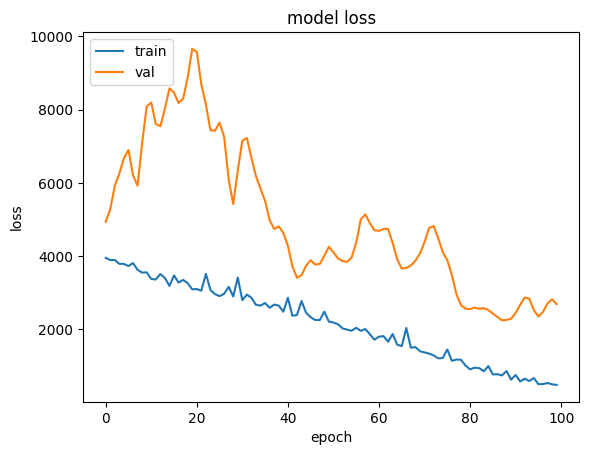

In [41]:
# loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

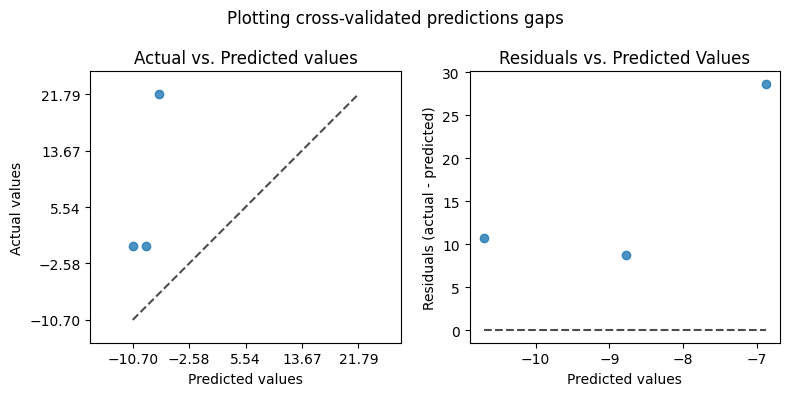

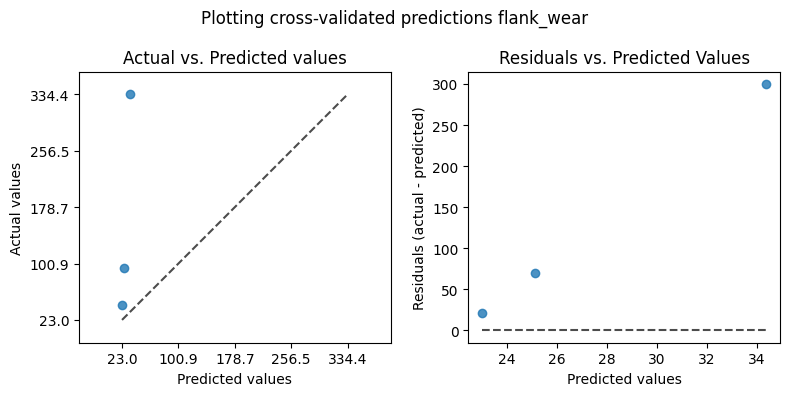

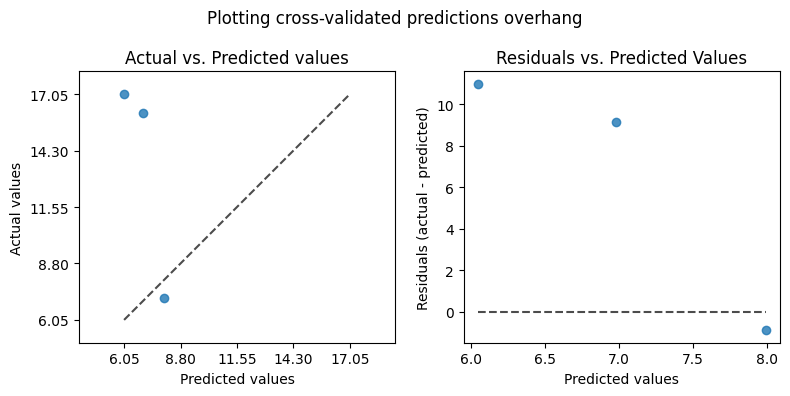

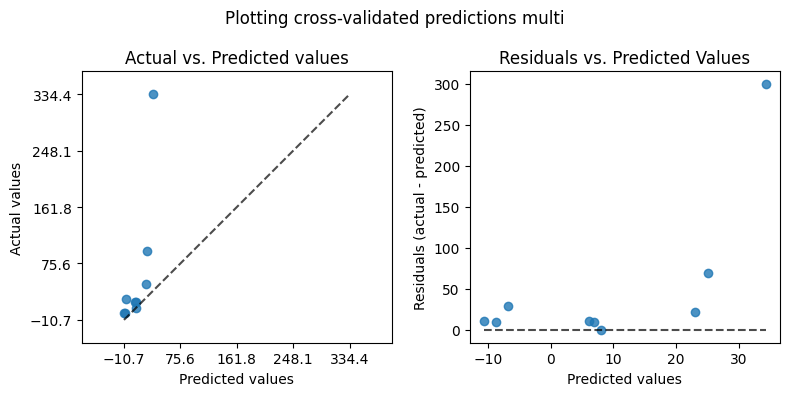

In [42]:
for label, y_pred, y_true in zip(labels_list, pred_list, true_list):
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_predict.html#sphx-glr-auto-examples-model-selection-plot-cv-predict-py
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=100,
        ax=axs[0],
        random_state=0,
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=100,
        ax=axs[1],
        random_state=0,
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting cross-validated predictions " + label)
    plt.tight_layout()
    plt.show()

In [43]:
def min_shift(list1, list2):
    list1 = np.array(list1)
    list2 = np.array(list2)
    if list1.ndim == 2:
        for i in range(len(list1)):
            if np.min([list1, list2]) > 0:
                continue
            min = np.min([list1[i], list2[i]])
            list1[i] -= min
            list2[i] -= min
        return list1, list2

    min = np.min([list1, list2])
    list1 = list1 - min
    list2 = list1 - min

    return list1, list2

In [44]:
for label, y_pred, y_true in zip(labels_list, pred_list, true_list):
    print(f"===== {label} results =====")
    print("MAE: ", metrics.mean_absolute_error(y_true, y_pred))
    print("MSE: ", metrics.mean_squared_error(y_true, y_pred))
    print("RMSE: ", metrics.mean_squared_error(y_true, y_pred, squared=False))
    print("r2_score: ", metrics.r2_score(y_true, y_pred))
    try:
        print("MSLE: ", metrics.mean_squared_log_error(y_true, y_pred))
    except ValueError as err:
        y_true_shift, y_pred_shift = min_shift(y_true, y_pred)
        print(
            "MSLE_min_shifted: ",
            metrics.mean_squared_log_error(y_true_shift, y_pred_shift),
        )
    print("MAPE: ", metrics.mean_absolute_percentage_error(y_true, y_pred))

===== gaps results =====
MAE:  16.049106610616047
MSE:  337.8022235632663
RMSE:  18.379396713800656
r2_score:  -2.201551979089267
MSLE_min_shifted:  0.306852636988362
MAPE:  2.924336430326306e+16
===== flank_wear results =====
MAE:  130.25861661275226
MSE:  31768.783630370093
RMSE:  178.23799715652692
r2_score:  -0.9827786028340821
MSLE:  2.382580830014581
MAPE:  0.7038515004384823
===== overhang results =====
MAE:  7.016391226450604
MSE:  68.56770895161549
RMSE:  8.280562115678832
r2_score:  -2.3990740986038137
MSLE:  0.49306588063358764
MAPE:  0.44597017819338175
===== multi results =====
MAE:  51.10803814993963
MSE:  10725.051187628325
RMSE:  68.29931866200214
r2_score:  -1.8611348935090541
MSLE_min_shifted:  3.228927245974089
MAPE:  9747788101087686.0
